<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Adapted from: https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb

In [1]:
import pandas as pd
import numpy as np
import os

names = ['time', 'u' , 'x', 'obs_num']

path = r"C:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\Optimal_Control_Toy"
df = pd.read_csv("data_N200.csv",sep=',', header=0, names=names,index_col=False)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.bfill(inplace=True)
df.ffill(inplace=True) #for obs num


print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

print(df.shape)

Starting file:
       time         u         x  obs_num
0  0.000000  0.250000  1.000000      1.0
1  0.000111  0.250014  1.000118      1.0
2  0.000222  0.250028  1.000236      1.0
3  0.000333  0.250042  1.000354      1.0
4  0.000444  0.250056  1.000472      1.0
5  0.000556  0.250069  1.000590      1.0
6  0.000667  0.250083  1.000708      1.0
7  0.000778  0.250097  1.000826      1.0
8  0.000889  0.250111  1.000945      1.0
9  0.001000  0.250125  1.001063      1.0
Ending file:
           time         u         x  obs_num
26990  0.999000  1.998000  3.328337      3.0
26991  0.999111  1.998222  3.328892      3.0
26992  0.999222  1.998444  3.329446      3.0
26993  0.999333  1.998667  3.330001      3.0
26994  0.999444  1.998889  3.330556      3.0
26995  0.999556  1.999111  3.331112      3.0
26996  0.999667  1.999333  3.331667      3.0
26997  0.999778  1.999556  3.332222      3.0
26998  0.999889  1.999778  3.332778      3.0
26999  1.000000  2.000000  3.333333      3.0
(27000, 4)


In [2]:
# import math

# def PE(j, d_model):
#     PE_list = []
#     for i, value in enumerate(df['time']):
#         if i % 2 == 0:
#             PE_list += [ math.sin(value/ (10000**(2*j / d_model)))]
#         else:
#             PE_list += [ math.cos(value/ (10000**(2*j / d_model)))]
            
#     return PE_list

# df['x_'] = df['x']
# df['u_'] = df['u']
# df['x'] = df['x'] + np.array(PE(0, 2))
# df['u'] = df['u'] + np.array(PE(1, 2))

df.head()

,time,u,x,obs_num
0,0.000000,0.250000,1.000000,1.0
1,0.000111,0.250014,1.000118,1.0
2,0.000222,0.250028,1.000236,1.0
3,0.000333,0.250042,1.000354,1.0
4,0.000444,0.250056,1.000472,1.0


In [3]:
# # Find the last zero and move one beyond
# start_id = max(df[df['obs_num'] == 0].index.tolist())+1
# print(start_id)
# df = df[start_id:] # Trim the rows that have missing observations

Divide into training and test/validation sets.

In [4]:
df['u'] = df['u'].astype(float)
df12 = df[df['obs_num']<3.0]
df123 = df[df['obs_num']<4.0]

df_train = df123[df123['time']<0.7]
df_test = df123[df123['time']>=0.7]

spots_train_u = df_train['u'].tolist()
spots_train_x = df_train['x'].tolist()
spots_train_t = df_train['time'].tolist()

spots_test_u = df_test['u'].tolist()
spots_test_x = df_test['x'].tolist()
spots_test_t = df_test['time'].tolist()

print("Training set has {} observations.".format(len(spots_train_u)))
print("Test set has {} observations.".format(len(spots_test_u)))
# print(spots_train)

Training set has 18900 observations.
Test set has 8100 observations.


In [5]:

df1 = df[df['obs_num']==1.0]
df2 = df[df['obs_num']==2.0]
df3 = df[df['obs_num']==3.0]

df_test1 = df1[df1['time']>=0.7]
df_test2 = df2[df2['time']>=0.7]
df_test3 = df3[df3['time']>=0.7]

spots_test1_u = df_test1['u'].tolist()
spots_test1_x = df_test1['x'].tolist()
spots_test1_t = df_test1['time'].tolist()

spots_test2_x = df_test2['x'].tolist()
spots_test2_u = df_test2['u'].tolist()
spots_test2_t = df_test2['time'].tolist()

spots_test3_x = df_test3['x'].tolist()
spots_test3_u = df_test3['u'].tolist()
spots_test3_t = df_test3['time'].tolist()

print("Test set 1 has {} observations.".format(len(spots_test1_u)))
print("Test set 2 has {} observations.".format(len(spots_test2_u)))
print("Test set 3 has {} observations.".format(len(spots_test3_u)))

Test set 1 has 2700 observations.
Test set 2 has 2700 observations.
Test set 3 has 2700 observations.


The **to_sequences** function takes linear time series data into an **x** and **y** where **x** is all possible sequences of seq_size. After each **x** sequence, this function places the next value into the **y** variable. These **x** and **y** data can train a time-series neural network.

In [6]:
import numpy as np

def to_sequences(SEQUENCE_SIZE, obs_x, obs_u, obs_t):

    x = []
    y = []
    for i in range((len(obs_x))-SEQUENCE_SIZE):

        window1 = obs_x[i:(i+SEQUENCE_SIZE)]  #[i:(i+SEQUENCE_SIZE)] 
        window2 = obs_u[i:(i+SEQUENCE_SIZE)] 
        after_window = [obs_x[i+SEQUENCE_SIZE]] 
        window = [[x, t] for x,t in zip(window1, window2)]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)

SEQUENCE_SIZE = 1
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train_x, spots_train_u, spots_train_t)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test_x, spots_test_u, spots_test_t)

print("Shape of x train set: {}".format(x_train.shape))
print("Shape of x test set: {}".format(x_test.shape))

print("Shape of y train set: {}".format(y_train.shape))
print("Shape of y test set: {}".format(y_test.shape))

Shape of x train set: (18899, 1, 2)
Shape of x test set: (8099, 1, 2)
Shape of y train set: (18899, 1)
Shape of y test set: (8099, 1)


In [7]:

x_test1, y_test1 = to_sequences(SEQUENCE_SIZE,spots_test1_x, spots_test1_u ,  spots_test1_t)
print("Shape of y1 test set: {}".format(y_test1.shape))

x_test2, y_test2 = to_sequences(SEQUENCE_SIZE,spots_test2_x, spots_test2_u,  spots_test1_t)
print("Shape of y2 test set: {}".format(y_test2.shape))

x_test3, y_test3 = to_sequences(SEQUENCE_SIZE,spots_test3_x, spots_test3_u,  spots_test1_t)
print("Shape of y3 test set: {}".format(y_test3.shape))

Shape of y1 test set: (2699, 1)
Shape of y2 test set: (2699, 1)
Shape of y3 test set: (2699, 1)


We can view the results of the **to_sequences** encoding of the sunspot data.

In [8]:

# print('func 1',x_train[0])
# print('func 2',x_train[1])

In [9]:
#!pip install tensorflow

In [10]:
pip show protobuf


Name: protobuf
Version: 4.25.3
Summary: 
Home-page: https://developers.google.com/protocol-buffers/
Author: protobuf@googlegroups.com
Author-email: protobuf@googlegroups.com
License: 3-Clause BSD License
Location: c:\users\sian_\onedrive\documents\thesis\milp_formulation\pyomo_env\lib\site-packages
Requires: 
Required-by: tensorboard, tensorflow-intel
Note: you may need to restart the kernel to use updated packages.


Next, we create the transformer_encoder; I obtained this function from a [Keras example](https://keras.io/examples/timeseries/timeseries_transformer_classification/). This layer includes residual connections, layer normalization, and dropout. This resulting layer can be stacked multiple times. We implement the projection layers with the Keras Conv1D.

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    ## NB dropout layer is only applied during training not inference (https://keras.io/api/layers/regularization_layers/dropout/)
    
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    # x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    # x = layers.Dropout(dropout)(x)
    # x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation="relu")(x)
    
    #x = layers.Conv2D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Conv2D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

In [24]:
def transformer_decoder(inputs, encoder_outputs, head_size, num_heads, ff_dim, dropout=0):
    # Masked multi-head self-attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x, attention_mask=create_look_ahead_mask(tf.shape(x)[1]))
    x = layers.Dropout(dropout)(attention_output)
    res = x + inputs

    # Cross-attention with encoder outputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, encoder_outputs)
    x = layers.Dropout(dropout)(attention_output)
    res = x + res

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    
    return x + res

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

The following function is provided to build the model, including the attention layer.

In [32]:


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.25,
    mlp_dropout=0.25,
):
   

    inputs = keras.Input(shape=input_shape)
    x = inputs
    print(x.shape)
    print(x.shape[1])
    #x = layers.Dense(4)(inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    encoder_outputs = x
    x = transformer_decoder(inputs, encoder_outputs, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

    
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    #x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    print(x.shape, x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="relu")(x)
    return keras.Model(inputs= [inputs, encoder_outputs], outputs = outputs)

In [33]:
# model parameters:
model_params = {
    'input_shape': (SEQUENCE_SIZE,2),
    'head_size': 5,
    'num_heads': 12,
    'ff_dim': 10, #32
    'num_transformer_blocks': 1,
    'mlp_units': [32], #24
    'mlp_dropout': 0.1,
    'dropout': 0.1,
    'validation_split': 0.2,
    'epochs':1000,
    'batch_size': 64,
    'learning_rate': 1e-6
}
"""
model_params = {
    'input_shape': x_train.shape[1:],
    'head_size': 10,
    'num_heads': 4,
    'ff_dim': 4,
    'num_transformer_blocks': 1,
    'mlp_units': [128],
    'mlp_dropout': 0,
    'dropout': 0,
    'validation_split': 0.2,
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 1e-3
}
"""

print(x_train[0,:,0].shape)

(1,)


We are now ready to build and train the model.

In [34]:


model = build_model(
    input_shape = model_params["input_shape"],
    head_size = model_params["head_size"],
    num_heads = model_params["num_heads"],
    ff_dim = model_params["ff_dim"],
    num_transformer_blocks = model_params['num_transformer_blocks'],
    mlp_units = model_params["mlp_units"],
    mlp_dropout = model_params["mlp_dropout"],
    dropout = model_params["dropout"],
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=model_params['learning_rate'])
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=2, \
    restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split = model_params["validation_split"],
    epochs = model_params["epochs"],
    batch_size = model_params["batch_size"],
    callbacks=callbacks,
    shuffle=True,
)

model.evaluate(x_test, y_test, verbose=1)

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


Finally, we evaluate the model with RMSE.

In [ ]:
name = 'TNN_1.keras'
model.save(name , overwrite=True)

In [ ]:
from sklearn import metrics

#score_x = np.sqrt(metrics.mean_squared_error(pred[:,0],y_test[:,0]))
#print("X Score (RMSE): {}".format(score_x))

#score_u = np.sqrt(metrics.mean_squared_error(pred[:,1],y_test[:,1]))
#print("U Score (RMSE): {}".format(score_u))

In [ ]:
preds_x = []
rmse_x = []
preds_u = []
rmse_u = []


for x,y in [[x_test1, y_test1],[x_test2, y_test2],[x_test3, y_test3]]:
    pred = model.predict(x)

    score_x = np.sqrt(metrics.mean_squared_error(pred[:,0],y[:,0]))
    print("X Score (RMSE): {}".format(score_x))
    preds_x.append(pred[:,0])
    rmse_x.append(score_x)
    try:
        score_u = np.sqrt(metrics.mean_squared_error(pred[:,1],y[:,1]))
        print("U Score (RMSE): {}".format(score_u))
        preds_u.append(pred[:,1])
        rmse_u.append(score_u)
    except:
        continue

print('Prediction shape: ', len(preds_x))

35/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

c:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\pyomo_env\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 12, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
X Score (RMSE): 1.946482549609861


c:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\pyomo_env\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 12, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
X Score (RMSE): 2.0666684548463263
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
X Score (RMSE): 2.7159524576835907
Prediction shape:  3


In [ ]:
# import csv
# # New filename for clarity
# new_filename = "results_small_relu_2.csv"

# # Create and write to the new CSV file with model parameters and results
# with open(new_filename, 'a', newline='') as file:
#     writer = csv.writer(file)
#     # Writing headers for model parameters
#     headers = list(model_params.keys())
#     headers.append('rmse_x_1')
#     headers.append('rmse_x_2')
#     headers.append('rmse_x_3')
#     headers.append('rmse_u_1')
#     headers.append('rmse_u_2')
#     headers.append('rmse_u_3')
#     headers.append(name)
#     writer.writerow(headers)
    
#     # Writing values
#     values = list(model_params.values())
#     values.append(rmse_x[0])  # Adding first RMSE
#     values.append(rmse_x[1])  # Adding second RMSE
#     values.append(rmse_x[2])  
#     values.append(rmse_u[0])  # Adding first RMSE
#     values.append(rmse_u[1])  # Adding second RMSE
#     values.append(rmse_u[2])
#     values.append('')
#     writer.writerow(values)

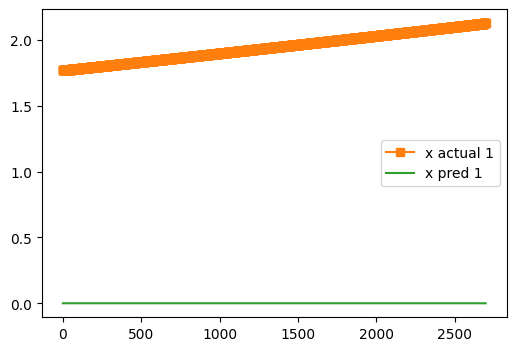

In [ ]:
import matplotlib.pyplot as plt
func = 0
plt.figure(figsize=(6, 4))
plt.plot(y_test1[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test1[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()

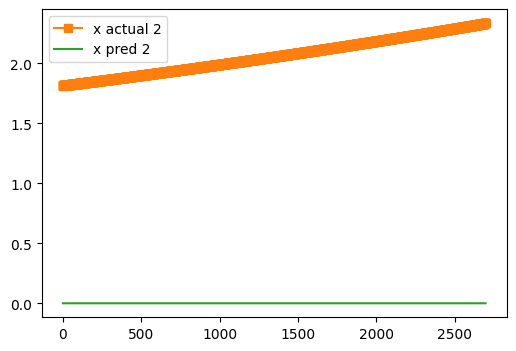

In [ ]:
import matplotlib.pyplot as plt
func = 1
plt.figure(figsize=(6, 4))
plt.plot(y_test2[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test2[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()

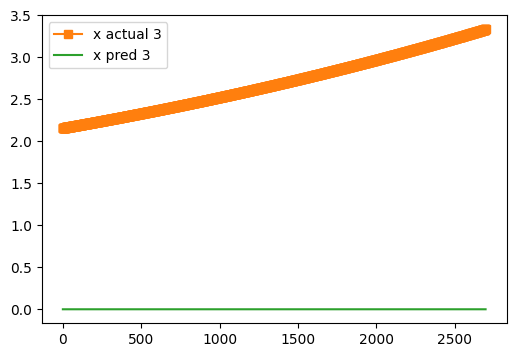

In [ ]:
import matplotlib.pyplot as plt
func = 2
plt.figure(figsize=(6, 4))
plt.plot(y_test3[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test3[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()